<a href="https://colab.research.google.com/github/yogso/music-generation/blob/master/Music_Generation_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#@title Import of necessary libraries and files { run: "auto", vertical-output: true, display-mode: "both" }
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Flatten, LSTM
from keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.externals import joblib
import numpy as np
import glob
from tqdm import tqdm
import midi_utils
import matplotlib.pyplot as plt
from keras.layers.core import Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import os.path

%cd /content

!apt-get install libasound2-dev swig
!pip install git+https://github.com/vishnubob/python-midi@feature/python3
  
%rm -rf /content/midi_utils* || true
%rm -rf /content/music-generation || true

!wget https://raw.githubusercontent.com/yogso/music-generation/master/midi_utils.py

!git clone https://github.com/yogso/music-generation.git

/content
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
  Cloning https://github.com/vishnubob/python-midi (to revision feature/python3) to /tmp/pip-req-build-ct4ka4u0
Branch 'feature/python3' set up to track remote branch 'feature/python3' from 'origin'.
Switched to a new branch 'feature/python3'
  Running setup.py bdist_wheel for midi ... - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr87g1oz/wheels/63/f9/4a/5e881f1126db389dfda75672c69b5be5bf51b0925cc7b5cbcf
Successfully built midi
--2018-11-13 20:42:26--  https://raw.githubusercontent.com/yogso/music-generation/master/midi_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com 

In [0]:
#@title Definition of training songs

#@markdown Source of the training songs.-
#@markdown 

songs_source = 'Use sample songs' #@param ["Use sample songs", "Upload custom songs"]

def custom_songs():
  from google.colab import files
  uploaded = files.upload()

  print('Songs uploaded correctly')
  
def sample_songs():

  %cp /content/music-generation/example_training_songs/* /content/canciones_entrenamiento
  
  print('Songs loaded correctly')
  
%cd /content

%rm -rf /content/canciones_entrenamiento || true

%mkdir /content/canciones_entrenamiento
%cd /content/canciones_entrenamiento

select_source = {"Upload custom songs" : custom_songs,
                 "Use sample songs" : sample_songs
                }

source = select_source.get(songs_source, 'Upload custom songs')

source()



%cd /content

  0%|          | 0/30 [00:00<?, ?it/s]

Loading songs...


  3%|▎         | 1/30 [00:00<00:21,  1.37it/s]

1761


  7%|▋         | 2/30 [00:01<00:20,  1.36it/s]

2204


 10%|█         | 3/30 [00:01<00:18,  1.50it/s]

1708


 13%|█▎        | 4/30 [00:02<00:18,  1.44it/s]

2516


 17%|█▋        | 5/30 [00:03<00:20,  1.25it/s]

2387


 20%|██        | 6/30 [00:06<00:33,  1.38s/it]

4957


 23%|██▎       | 7/30 [00:07<00:29,  1.29s/it]

2014


 27%|██▋       | 8/30 [00:08<00:27,  1.27s/it]

2399


 30%|███       | 9/30 [00:10<00:28,  1.35s/it]

2731


 33%|███▎      | 10/30 [00:10<00:22,  1.11s/it]

1785


 37%|███▋      | 11/30 [00:13<00:29,  1.56s/it]

5281


 40%|████      | 12/30 [00:15<00:28,  1.57s/it]

3153


 43%|████▎     | 13/30 [00:15<00:22,  1.32s/it]

1777


 47%|████▋     | 14/30 [00:16<00:17,  1.09s/it]

1553


 50%|█████     | 15/30 [00:17<00:17,  1.16s/it]

3649


 53%|█████▎    | 16/30 [00:18<00:14,  1.01s/it]

2369


 57%|█████▋    | 17/30 [00:18<00:10,  1.28it/s]

1265


 60%|██████    | 18/30 [00:19<00:08,  1.37it/s]

1939


 63%|██████▎   | 19/30 [00:20<00:08,  1.29it/s]

1617


 67%|██████▋   | 20/30 [00:21<00:08,  1.15it/s]

1745


 70%|███████   | 21/30 [00:21<00:06,  1.30it/s]

1153


 73%|███████▎  | 22/30 [00:22<00:07,  1.11it/s]

2033


 77%|███████▋  | 23/30 [00:24<00:07,  1.04s/it]

2481


 80%|████████  | 24/30 [00:26<00:07,  1.25s/it]

3281


 83%|████████▎ | 25/30 [00:27<00:06,  1.24s/it]

2129


 87%|████████▋ | 26/30 [00:28<00:05,  1.26s/it]

2401


 90%|█████████ | 27/30 [00:30<00:03,  1.31s/it]

2645


 93%|█████████▎| 28/30 [00:32<00:03,  1.67s/it]

4897


 97%|█████████▋| 29/30 [00:34<00:01,  1.74s/it]

3829


100%|██████████| 30/30 [00:35<00:00,  1.39s/it]

1185
30 songs were loaded


Inputs number: 74694
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 400)               312400    
_________________________________________________________________
dropout_12 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_13 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_24 (Dense)             (None, 156)               62556     
_________________________________________________________________
activation_6 (Activation)    (None, 156)               

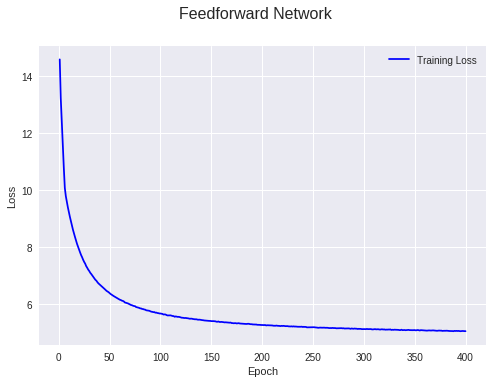

In [11]:
#@title Automatic generation of music through Machine Learning techniques

#@markdown ### Parameters definition

#@markdown Model that will be used.-

Model_dropdown = 'Feedforward Network' #@param ["Feedforward Network", "Decision Tree", "Random Forest", "LSTM Network", "Convolutional Network"]

#@markdown Size of the samples of the songs from which you are going to learn.-

previous_times = 5 #@param {type:"slider", min:5, max:20, step:1}

#@markdown Number of complete training cycles to be performed in the training set.-

epoch = 400 #@param {type:"integer"}


#@markdown ---
#@markdown ### New songs generation

#@markdown Number of songs you want to generate.-


num_songs = 10 #@param {type:"integer"}


minimum_length=15                 #Minimum size (in times) that the songs of the training set should have
songs_directory='canciones_entrenamiento'     #Directory where the training songs are
saved_model='mejor_modelo.hdf5'  #Name of the file where the trained model will be stored


#Eliminate the empty times that are at the beginning of the songs
def delete_first_zeros(arr):
  i=0
  ceros=np.zeros_like(arr[0])
  tamano=np.size(arr,0)
  while np.array_equal(arr[i],ceros) and tamano!=1:
    arr=np.delete(arr,i, axis=0)
    tamano=tamano-1
  return arr

def read_songs(ruta):
  print('Loading songs...')
  files = glob.glob('{}/*.mid*'.format(ruta))
  files = np.array(np.sort(files))
  files = files.tolist()
  global songs
  global song_num
  songs = list()
  song_num=0
  for f in tqdm(files):
    #print(f)
    try:
      cancion = np.array(midi_utils.midiToNoteStateMatrix(f))			#Convert .mid files to arrays
      cancion=delete_first_zeros(cancion)
      tam = np.array(cancion).shape[0]
      print(tam)
      if tam > minimum_length:
          songs.append(cancion)
          song_num=song_num+1
    except Exception as e:
      raise e
  return songs

#Convert the 2D array of inputs into a 3D array to train the system
def dim_conversion(w):
  for t, val in enumerate(w):
    u[0, t] = val
  return u


def inputs_feedforward():
  #Divide the songs into two arrays, one for the previous times and one for the time of departure  

  sentences=[]
  next_values=[]
  for song in songs:
    for i in range(0, len(song) - previous_times):
      sentences.append(song[i: i + previous_times])
      next_values.append(song[i + previous_times])
  
  X = np.zeros((len(sentences), previous_times*156), dtype=np.int32)
  for i, sentence in enumerate(sentences):
    X[i] = sentence.ravel() 
  y = np.asarray(next_values)
  
  print("Inputs number: {}".format(len(y)))
  return X, y


def inputs_other_networks():
  #Divide the songs into two arrays, one for the previous times and one for the time of departure 

  sentences=[]
  next_values=[]
  for song in songs:
    for i in range(0, len(song) - previous_times):
      sentences.append(song[i: i + previous_times])
      next_values.append(song[i + previous_times])
      
  #Convert sets of previous times into a three-dimensional array

  X = np.zeros((len(sentences), previous_times, 156), dtype=np.int32)
  for i, sentence in enumerate(sentences):
    for t, val in enumerate(sentence):
      X[i, t] = val
  y = np.asarray(next_values)
  print("Inputs number: {}".format(len(y)))
  return X, y

def inputs_trees():
  X=[]
  y=[]
  for song in songs:
    for i in range(0, len(song) - previous_times):
      X.append(np.ravel(song[i: i + previous_times]))
      y.append(song[i + previous_times])
  print("Inputs number: {}".format(len(y)))
  return X, y


  #Load songs
songs = read_songs(songs_directory)
print("{} songs were loaded".format(song_num))

def plot_loss(history, model_name):
  # list all data in history
  print(history.history.keys())
  
  # Get training loss histories
  training_loss = history.history['loss']
  #test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  
  plt.plot(epoch_count, training_loss, 'b-')
  plt.legend(['Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.suptitle(model_name, fontsize=16)
  plt.show()

#Define model to use

def feedforwardNetworkImpl():
  
  X, y = inputs_feedforward()
  
  model = Sequential()
  model.add(Dense(400, activation='relu', input_dim=(previous_times*156)))
  model.add(Dropout(0.1))
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(156))
  model.add(Activation('sigmoid'))
  
  model.summary()

  #Define how the model is saved

  model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['categorical_crossentropy'])
  checkpoint = ModelCheckpoint(saved_model, monitor='categorical_crossentropy', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  #Train model

  print("Training...")
  history = model.fit(X, y, epochs=epoch, batch_size=2000, callbacks=callbacks_list)

  print ("The model has been successfully trained")
  
  #Evaluate model
  print("The error obtained with the model is: {}". format(model.evaluate(X, y, batch_size=200, verbose=1)))
  
  #print(history.History)
  
  plot_loss(history,'Feedforward Network')

  return model

  
def decisionTreeImpl():
  
  X, y = inputs_trees()
  
  profundidad_arbol = 100

  #Training
  model = tree.DecisionTreeClassifier(max_depth=profundidad_arbol)
  
  print("Training...")
  model = model.fit(X, y)

  print ("The model has been successfully trained")

  #Evaluate model
  print("The error obtained with the model is: {}". format(log_loss(np.asarray(y), np.asarray(model.predict(X)))))
  
  return model

  
def randomForestImpl():
  
  X, y = inputs_trees()
  
  profundidad_arbol=100                     #Maximum depth of each individual tree
  num_trees=15                       #Trees that will be created in the forest

  model = RandomForestClassifier(max_depth=profundidad_arbol, n_estimators=num_trees)
  print("Training...")
  model = model.fit(X, y)

  print ("The model has been successfully trained")

  #Evaluate model
  print("The error obtained with the model is: {}". format(log_loss(np.asarray(y), np.asarray(model.predict(X)))))
  
  return model
  

def lstmNetworkImpl():
  
  X, y = inputs_other_networks()
  
  #Define neural network
  
  len(songs)

  model = Sequential()
  model.add(LSTM(400, activation='relu', input_shape=(previous_times, 156), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(400, activation='relu', return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(400, return_sequences=False))
  model.add(Dense(156))
  model.add(Activation('sigmoid'))

  #Define how the model is saved

  model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['categorical_crossentropy'])
  checkpoint = ModelCheckpoint(saved_model, monitor='categorical_crossentropy', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  #Train model
  print("Training...")
  history = model.fit(X, y, epochs=epoch, batch_size=1200, callbacks=callbacks_list)

  print ("The model has been successfully trained")

  #Evaluate model
  print("The error obtained with the model is: {}". format(model.evaluate(X, y, batch_size=1200, verbose=1)))
  plot_loss(history,'LSTM Network')
  
  return model
  
def convolutionalNetworkImpl(): 
  
  X, y = inputs_other_networks()

  #Define neural network 
  filtros=40

  model = Sequential()
  model.add(Reshape((previous_times, 156, 1), input_shape=(previous_times, 156)))
  model.add(Conv2D(kernel_size=4, filters=filtros, strides=1, padding='same', activation='relu', data_format='channels_last'))
  model.add(Conv2D(kernel_size=4, filters=filtros, strides=1, padding='same', activation='relu', data_format='channels_last'))
  model.add(Conv2D(kernel_size=4, filters=filtros, strides=1, padding='same', activation='relu', data_format='channels_last'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Dense(600))
  model.add(Dense(156))
  model.add(Activation('sigmoid', name='sigmoid'))

  #Define how the model is saved
  model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['categorical_crossentropy'])
  checkpoint = ModelCheckpoint(saved_model, monitor='categorical_crossentropy', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  #Train model
  print("Training...")
  history = model.fit(X, y, epochs=epoch, batch_size=1200, callbacks=callbacks_list)

  print ("The model has been successfully trained")

  #Evaluate model
  print("The error obtained with the model is: {}". format(model.evaluate(X, y, batch_size=1200, verbose=1)))
  plot_loss(history,'Convolutional Network')
  return model

op_models = {"Feedforward Network" : feedforwardNetworkImpl,
           "Decision Tree" : decisionTreeImpl, 
           "Random Forest" : randomForestImpl, 
           "LSTM Network" : lstmNetworkImpl, 
           "Convolutional Network" : convolutionalNetworkImpl
          }

func_model = op_models.get(Model_dropdown, 'Feedforward Network')

model = func_model()

print('Generating new songs...')


#NEW SONGS GENERATION

!rm -rf /content/canciones_generadas || true

%mkdir /content/canciones_generadas


songs_length=800         #Number of times the songs generated will have


#Randomly generate initial entry
  
cancion_base = np.random.choice([0, 1], size=(previous_times,156),  p=[0.95,0.05])
plt.imshow(cancion_base)
 
  
for num_song in tqdm(range (1,num_songs)):
  
  u = np.zeros((1, previous_times, 156), dtype=np.int32)
  songs_length=songs_length+previous_times
  ent=np.zeros((songs_length,156))
  ent[0:previous_times,:]=cancion_base
  for i in range (0,songs_length-previous_times):			#Songs creation
    if Model_dropdown == "Decision Tree" or Model_dropdown == "Random Forest":
      nueva_fila = model.predict(np.reshape(ent[i:i+previous_times,:].ravel(),(1,previous_times*156)))
    else:
      if Model_dropdown == 'Feedforward Network':
        nueva_fila = model.predict(np.reshape(ent[i:i+previous_times,:].ravel(),(1,previous_times*156)), batch_size=1, verbose=1)
      else:
        nueva_fila = model.predict(dim_conversion(ent[i:i+previous_times,:]), batch_size=1, verbose=1)
    if (np.all(np.round_(nueva_fila)==0)):
      nueva_fila[0,np.argsort(-nueva_fila)[0,:4]]=1
    ent[i+previous_times] = nueva_fila
    ent=np.round_(ent)

  ent=ent[previous_times:songs_length+previous_times,:]

  #Save midi file
  midi_utils.noteStateMatrixToMidi(ent, "/content/canciones_generadas/new_song{}".format(num_song))
    
  
for f in range (1,num_songs):
  files.download("/content/canciones_generadas/new_song{}.mid".format(f))
